# VAE model
##### Script for training model

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
NAME="VAE-save"

### Mount google drive


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/praca_mgr'
os.chdir(path)

Mounted at /content/drive


### Load and process data

In [ ]:
# load the dataset
data = load('data/data_nonrandom_responses.npz')["arr_0"]
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = load('data/data_nonrandom_particles.npz')["arr_0"]
data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
COND_DIM=data_cond.shape[-1]
print('Loaded cond: ',  data_cond.shape)

Loaded:  (295867, 44, 44) max: 591.0
Loaded cond:  (295867, 9)


In [ ]:
# # load small  dataset
# data = load('data/data_nonrandom_responses.npz')["arr_0"][:10000]
# print('Loaded: ',  data.shape, "max:", data.max())

# data_cond = load('data/data_nonrandom_particles.npz')["arr_0"][:10000]
# data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
# COND_DIM=data_cond.shape[-1]
# print('Loaded cond: ',  data_cond.shape)

In [ ]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

data max 6.383507 min 0.0
cond max 10.15001 min -20.507631


In [ ]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(236693, 44, 44) (59174, 44, 44) (236693, 9) (59174, 9)


In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.5.0


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)


### Define Model

In [ ]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 10
cond_dim = 9
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[44,44,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond,x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(6*6*128)(inputs)
g = Reshape((6,6,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=5,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 44, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 22, 32)   544         input_img[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 64)   32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 128)    131200      conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [ ]:
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [ ]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [ ]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0,1,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    try:
      ch_gen = np.array(results).reshape(-1,44,44)
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)
  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,44,44,1)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss    
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))       

    return total_loss, reconstruction_loss, kl_loss

In [ ]:
history = []
def train(dataset, epochs):
  tf_step =tf.Variable(0, dtype=float)
  step=0
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
  #print(calculate_ws_mae(3))
  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
      history.append([total_loss, reconstruction_loss, kl_loss])
      tf_step.assign_add(1)
      step = step+1

      if step%100==0:
        print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
            step, total_loss, reconstruction_loss, kl_loss))

      if step%1000==0:
          generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])

    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond]
                             )

    # Save the model every epoch
    encoder.save_weights("enc_"+NAME + "_"+ str(epoch) +".h5")
    generator.save_weights("gen_"+NAME + "_"+ str(epoch) +".h5")
    np.savez("history_"+NAME+".npz",np.array(history))

    calculate_ws_ch(min(epoch//5+1,5))

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return history

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig, axs = plt.subplots(2, 7, figsize=(15,4))
  for i in range(0,14):
    if i <7:
        x = x_test[20+i].reshape(44,44)
    else:
        x = predictions[i-7].numpy().reshape(44,44)
    #x[x<=0]=x.max()*-0.1
    im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
    axs[i//7,i%7].axis('off')
    fig.colorbar(im, ax=axs[i//7,i%7])
  plt.show()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

### Train model
##### only for 1 epoch for presentation

100 [Total loss: 129.55] [Recon_loss: 121.64] [KL loss: 11.31]
200 [Total loss: 96.35] [Recon_loss: 87.11] [KL loss: 13.20]
300 [Total loss: 99.86] [Recon_loss: 89.59] [KL loss: 14.67]
400 [Total loss: 88.01] [Recon_loss: 77.52] [KL loss: 14.99]
500 [Total loss: 86.94] [Recon_loss: 77.62] [KL loss: 13.30]
600 [Total loss: 94.95] [Recon_loss: 86.22] [KL loss: 12.48]
700 [Total loss: 90.49] [Recon_loss: 79.86] [KL loss: 15.19]
800 [Total loss: 69.92] [Recon_loss: 62.53] [KL loss: 10.56]
900 [Total loss: 69.27] [Recon_loss: 61.78] [KL loss: 10.70]
1000 [Total loss: 76.53] [Recon_loss: 67.15] [KL loss: 13.41]


<Figure size 432x288 with 0 Axes>

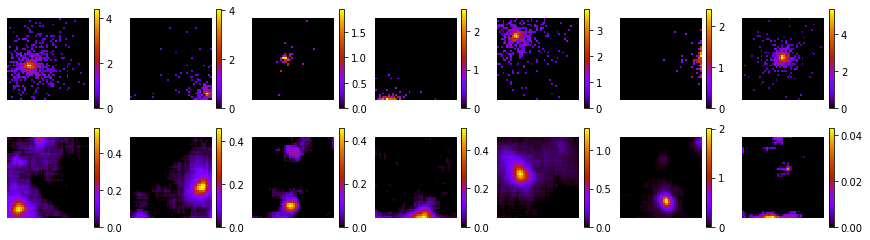

1100 [Total loss: 73.31] [Recon_loss: 65.39] [KL loss: 11.32]
1200 [Total loss: 80.52] [Recon_loss: 71.50] [KL loss: 12.89]
1300 [Total loss: 76.35] [Recon_loss: 67.68] [KL loss: 12.38]
1400 [Total loss: 83.84] [Recon_loss: 76.00] [KL loss: 11.20]
1500 [Total loss: 86.70] [Recon_loss: 78.87] [KL loss: 11.18]
1600 [Total loss: 79.20] [Recon_loss: 70.55] [KL loss: 12.36]
1700 [Total loss: 79.54] [Recon_loss: 71.08] [KL loss: 12.10]
1800 [Total loss: 73.41] [Recon_loss: 65.55] [KL loss: 11.23]


<Figure size 432x288 with 0 Axes>

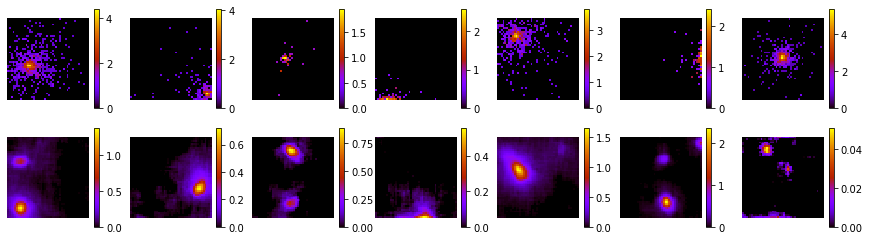

ws mean 67.73 ch1 41.45 ch2 40.24 ch3 42.46 ch4 44.52 ch5 169.99 Time for epoch 1 is 44.97937321662903 sec


<Figure size 432x288 with 0 Axes>

In [ ]:
history=train(dataset_with_cond, 1)

### Load best model described in thesis

In [ ]:
generator=tf.keras.models.load_model('models/generator_VAE.h5')

In [ ]:
generate_and_save_images(generator,
                          34,
                          [seed, seed_cond]
                          )
calculate_ws_ch(5)

ws mean 6.40 ch1 4.61 ch2 5.22 ch3 4.16 ch4 4.33 ch5 13.66 

<Figure size 432x288 with 0 Axes>